# Neural Scattering Fields Demo (TBD)
In this notebook, we use our `lego-mist` scene to demonstrate our multiple-scattering NeRF.\
(Alternatively to this demo, you can also run the model from the command line using `python3 run_nerf.py <path to data> <output path> <environment map path>`)

First, we start by fetching and processing the data (images and poses).\
**NOTE:** utils.load_transforms_json only handles instant-NGP-like json formatting.\
Hence, this will not work out the box with synthetic-NeRF datasets.\
(Take a look at `data/lego_mist/transforms_train.json` file for an example.)

In [1]:
# autoreload imports for dev
%load_ext autoreload
%autoreload 2

In [2]:
import os
import utils

base_path = "../lego_mist"
# get train and test data
train_dict  = utils.load_transforms_json(os.path.join(os.getcwd(), base_path), "transforms_train.json")
test_dict   = utils.load_transforms_json(os.path.join(os.getcwd(), base_path), "transforms_test.json")
train_imgs  = utils.get_images_from_folder(os.path.join(os.getcwd(), base_path, "train"))

# Here, our dataset doesn't have test image GTs due to the long process of rendering reference images.
# Hence, it will be used only to demonstrate novel view synthesis.
# test_imgs   = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego_mist", "test"))

### Camera Pose Visualization
As a sanity check, we can visualize the camera positions and their viewing directions.\
Here, it looks good; all cameras are looking inward towards our scene object.\
We can also visualize our expected test poses: a circular orbit around the scene on the xy plane.

Train poses:


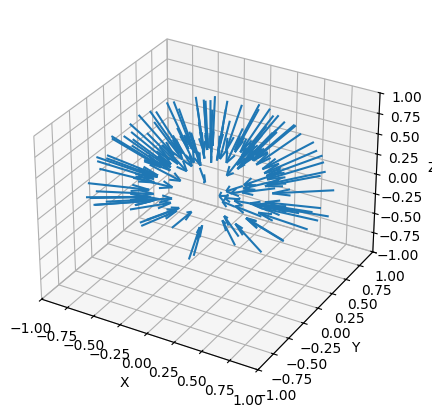

Test poses:


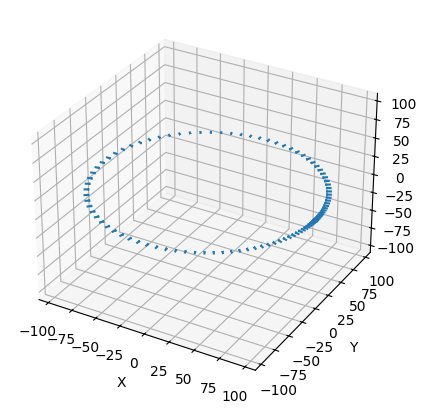

In [3]:
from render import get_camera_poses, get_camera_poses_normalized
import ms_nerf as ms
import torch

train_poses = train_dict["poses"]
test_poses  = test_dict["poses"]
focal_x, focal_y = train_dict["focal"][:]
N_train = train_poses.shape[0]
N_test  = test_poses.shape[0]

print("Train poses:")
utils.ray_plot(*get_camera_poses(train_poses, transpose=False, normalize=True))
print("Test poses:")
utils.ray_plot(*get_camera_poses(test_poses, transpose=False, normalize=False)) # debug this

Scene Center: tensor([[ 0.7624,  0.9396, 52.9996]]), Scale: 126.34552764892578
Train poses:
Train: (tensor([-0.5303,  0.2562,  0.2764]), tensor([ 0.5759, -0.2896, -0.7645]))
Train: (tensor([-0.1820, -0.7985, -0.0050]), tensor([ 0.1934,  0.8691, -0.4554]))
Train: (tensor([-0.1448,  0.2357,  0.4466]), tensor([ 0.1524, -0.2671, -0.9515]))


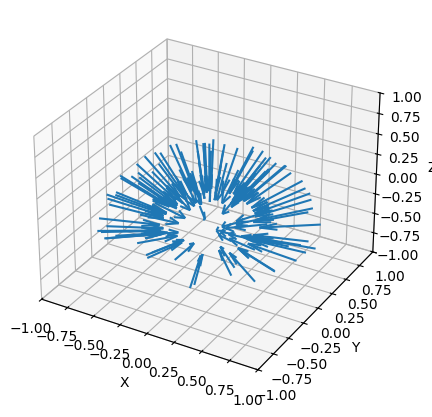

Test poses:
Test: (tensor([ 0.8644, -0.0074, -0.3403]), tensor([-0.9305,  0.0080,  0.3663]))
Test: (tensor([ 0.8644, -0.0058, -0.3403]), tensor([-0.9305,  0.0062,  0.3663]))
Test: (tensor([ 8.6441e-01, -8.2954e-04, -3.4033e-01]), tensor([-9.3048e-01,  8.9294e-04,  3.6635e-01]))


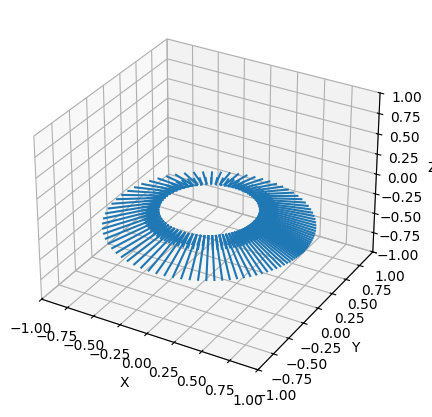

In [5]:
train_origins_raw, _ = get_camera_poses(train_poses, transpose=False, normalize=False)
scene_center = train_origins_raw.mean(dim=0, keepdim=True)  # shape (1,3)
scale = torch.max(torch.norm(train_origins_raw - scene_center, dim=-1))
print(f"Scene Center: {scene_center}, Scale: {scale}")

print("Train poses:")
utils.ray_plot(*get_camera_poses_normalized(train_poses, transpose=False, normalize=True, center=scene_center, scale=scale))
print("Test poses:")
utils.ray_plot(*get_camera_poses_normalized(test_poses, transpose=False, normalize=True, is_test=True, center=scene_center, scale=scale))

## Ray Tracing
Just as a ray tracer does, we shoot a ray through each "pixel" of the virtual image plane.

## Network
After this, we set up our component modules for our `NeuralScatteringField`, defined in `ms_nerf.py`.

### Positional Encoder

torch.Size([105, 4, 4])

In [21]:
x_encoder = ms.PositionalEncoder(3, 8, include_input=True, device="cpu") # change to 'cuda' when working for real
d_encoder = ms.PositionalEncoder(3, 1, include_input=True, device="cpu") # change to 'cuda' when working for real
x_enc = x_encoder(train_poses.view(N, -1))
d_enc = d_encoder(train_poses.view(N, -1))
print(x_enc.shape, d_enc.shape)

torch.Size([28560]) torch.Size([5040])


### Intemediate Networks

### Forward Pass

#### An example of phase function sampling (Henyey-Greenstein vs Uniform Sampling)
This is what we use to sample rays in single-scattering.\
**NOTE:** Sampling using `sample_next_directions` is relative to the ray coordinate frame.\
These need to be transformed into the world frame by using `local_to_world_rotation`.

torch.Size([6, 64, 2])


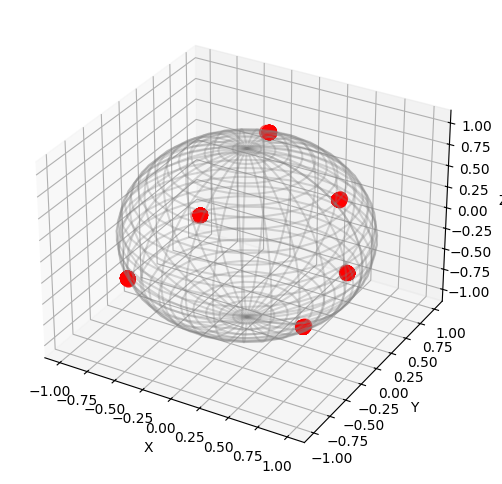

In [ ]:
# test code
# from utils import cartesian_to_spherical
# from render import eval_env_map
# from PIL import Image

# theta_phi = cartesian_to_spherical(sample_next_directions(torch.rand(6,3) * 2 - 1, phase_function=lambda u,v:sample_henyey_greenstein(u,v,g=0.9999), num_samples=64))
# print(theta_phi.shape)
# visualize_spherical_samples(*theta_phi.T)
# eval_env_map(torch.rand(16,3), torch.tensor(np.array(Image.open("env_map_example.png")))[...,:3])


[PDF] 0.999 aligned at g=0.99:	 307.8355811394921
[PDF] 0.999 aligned at g=0.9999: 5.627117655687526


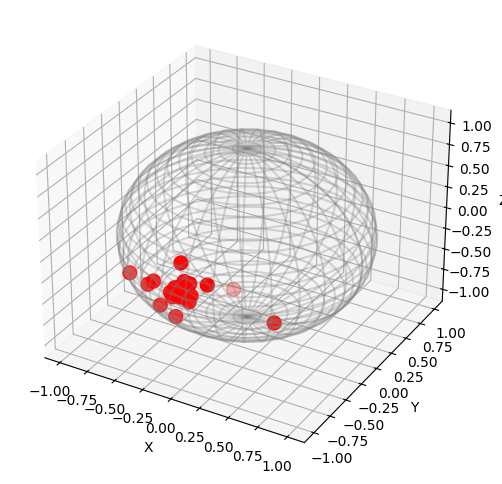

In [589]:
from render import henyey_greenstein_pdf, sample_henyey_greenstein
from sh import visualize_spherical_samples
from utils import local_to_world_rotation, spherical_to_cartesian, cartesian_to_spherical

# local to world position
ray_dir = torch.tensor([0,-1,0], dtype=torch.float32)  # w.r.t world
R = local_to_world_rotation(ray_dir.reshape(-1,3))

# generate samples; play with 'g' and see how sampling densities change throughout the spherical area
# NOTE: lots of discrepancy between 0.99 and 0.9999. The sensitivity to change is highly non-linear
# (maybe this could impact training? Maybe there's a transformation that can make this behave better.)
# additonally, if you check the henyey_greenstein_pdf, you can see that if g ~= 1, then even the smallest offset
# of cos_theta can go from extremely high probability density to very low ones.
print("[PDF] 0.999 aligned at g=0.99:\t", henyey_greenstein_pdf(1 - 1e-4, g=0.99))
print("[PDF] 0.999 aligned at g=0.9999:", henyey_greenstein_pdf(1 - 1e-4, g=0.9999))

theta_phi = sample_henyey_greenstein(*torch.rand(2, 128), g=0.99) # w.r.t the current ray direction
local_dirs = spherical_to_cartesian(theta_phi) # (num_samples, 3)
world_dirs = torch.einsum("bij,kj->bki", R, local_dirs)
theta_phi = cartesian_to_spherical(world_dirs.squeeze(0))
visualize_spherical_samples(*theta_phi.T)

Below is the same visualization, but using an **isotropic phase function**, which is equivalent to g=0.\
This is used in multiple scattering using the learned SH coefficients from the SH network.

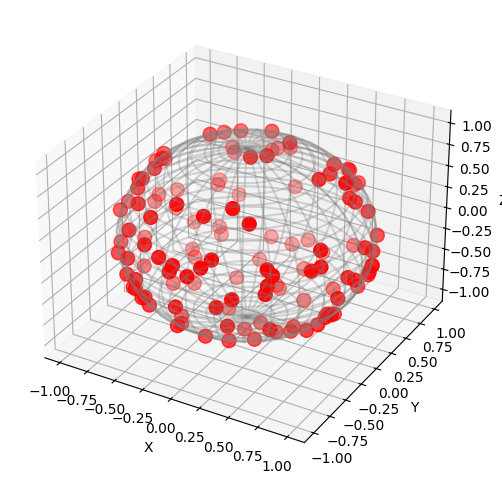

In [590]:
from sh import visualize_spherical_samples
from render import sample_isotropic
# because uniform/isotropic distribution, we can omit ray to world frame transformations
# since all directions are equally likely

# generate samples; play with 'g' and see how sampling densities change throughout the spherical area
theta_phi2 = sample_isotropic(*torch.rand(2, 128))
visualize_spherical_samples(*theta_phi2.T)

## Class Setup

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
from ms_nerf_main import NeuralScatteringField, get_rays
from PIL import Image


class NeRFDataset(Dataset):
    def __init__(self, data_dir, split='train'):
        self.data_dir = data_dir
        self.split = split
        self.meta, self.frames = self.load_transforms()
        self.data = self.load_data()

    def load_transforms(self):
        transforms_path = os.path.join(self.data_dir, f'transforms_{self.split}.json')
        with open(transforms_path, 'r') as f:
            meta = json.load(f)
        return meta, meta['frames']

    def load_data(self):
        data = []
        for frame in self.frames:
            img_path = os.path.join(self.data_dir, frame['file_path'])
            if not os.path.exists(img_path):
                img_path += '.png'  # Add extension if missing
            img = Image.open(img_path)
            img = torch.tensor(np.array(img), dtype=torch.float32) / 255.0
            
            # Verify image dimensions
            if img.shape[0] != self.meta['h'] or img.shape[1] != self.meta['w']:
                raise ValueError(f"Image {frame['file_path']} dimensions don't match metadata")
            
            data.append({
                'pose': torch.tensor(frame['transform_matrix'], dtype=torch.float32),
                'image': img.permute(2, 0, 1),  # HWC to CHW
                'fl_x': self.meta['fl_x'],
                'fl_y': self.meta['fl_y'],
                'cx': self.meta['cx'],
                'cy': self.meta['cy'],
                'width': self.meta['w'] if self.meta['w'] else 0,
                'height': self.meta['h']
            })
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Config:
    def __init__(self, data_dir: str):
        self.data_dir = data_dir
        self.ckpt_dir = './checkpoints'
        self.batch_size = 4
        self.epochs = 20
        self.lr = 5e-4
        self.near = 2.0
        self.far = 6.0
        self.num_coarse = 64
        self.num_fine = 128
        self.white_background = False

In [ ]:
data_path = "../lego_mist"
config = Config(data_dir=data_path)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img = cv2.imread("../space.hdr", flags=cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img.astype(np.float32))
img = img.permute(2, 0, 1).unsqueeze(0)  # Add batch dimension
env_map = img.to(device)

model = NeuralScatteringField(
    pos_enc_dim=16,
    dir_enc_dim=4,
    hidden_dim=256,
    lmax=2,
    env_map=env_map
).to(device)

os.makedirs(config.ckpt_dir, exist_ok=True)

## Training
Here, we borrow training metadata from the *Neural Relightable Participating Media Rendering* (Zheng et al.) paper.\
At the current time of construction, our model is pretty much the same as theirs, except ours is more constrained in only allowing environment map lighting.\
We train the model for 200K iterations, with a batch of 1200 primary rays each batch.\
We also decay the learning rate from $1\times 10^{-4}\to 1\times 10^{-5}$.

In [ ]:
# call training loop from ms_nerf
def train(model, device, config):
    train_dataset = NeRFDataset(config.data_dir, 'train')
    # test_dataset = NeRFDataset(config.data_dir, 'test')
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    # test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    best_psnr = 0
    loss = []
    
    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Train Epoch {epoch+1}'):
            poses = batch['pose'].to(device)
            images = batch['image'].to(device)
            
            # Generate rays
            rays_o, rays_d = get_rays(
                poses=poses,
                fl_x=batch['fl_x'].to(device),
                fl_y=batch['fl_y'].to(device),
                cx=batch['cx'].to(device),
                cy=batch['cy'].to(device),
                width=batch['width'][0].item(),
                height=batch['height'][0].item()
            )
            
            # Forward pass
            outputs = model.forward(
                rays_o=rays_o,
                rays_d=rays_d,
                near=config.near,
                far=config.far,
                num_coarse=config.num_coarse,
                num_fine=config.num_fine
            )
            
            # Compute loss
            loss = F.mse_loss(outputs['fine']['rgb_map'], images)
            
            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss.append(epoch_loss)
        print(f"Epoch: {epoch} | Loss: {epoch_loss}")
        # # Validation
        # test_psnr = test(model, test_loader, device, config)
        # scheduler.step()
        
        # print(f"Epoch {epoch+1:03d}: "
        #       f"Train Loss = {epoch_loss/len(train_loader):.4f}, "
        #       f"Test PSNR = {test_psnr:.2f}")
        
        # # Save best model
        # if test_psnr > best_psnr:
        #     best_psnr = test_psnr
        #     torch.save(model.state_dict(), os.path.join(config.ckpt_dir, 'best_model.pth'))
    return loss

In [ ]:
loss = train(model, device, config)

## Testing
Here, we render the scene using test poses unseen during training.

In [ ]:
# choose some random test poses and render their views
def test(model, test_loader, device, config):
    model.eval()
    total_psnr = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            poses = batch['pose'].to(device)
            
            # Generate rays
            rays_o, rays_d = get_rays(
                poses=poses,
                fl_x=batch['fl_x'].to(device),
                fl_y=batch['fl_y'].to(device),
                cx=batch['cx'].to(device),
                cy=batch['cy'].to(device),
                width=batch['width'][0].item(),
                height=batch['height'][0].item()
            )
            
            # Render image
            outputs = model.nerf_forward(
                rays_o=rays_o,
                rays_d=rays_d,
                near=config.near,
                far=config.far,
                num_coarse=config.num_coarse,
                num_fine=config.num_fine
            )
            
            # Calculate PSNR
            pred = outputs['fine']['rgb_map']
            target = batch['image'].to(device)
            mse = torch.mean((pred - target) ** 2)
            psnr = -10.0 * torch.log10(mse)
            total_psnr += psnr.item()
    
    return total_psnr / len(test_loader)